In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import statsmodels.formula.api as smf
import datetime as dt

from Package.PlotHandler import *

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 설정
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# Data Load
raw_data_df = pd.read_excel('Data/데이터 취합(240528).xlsx')

In [3]:
tidy_data = raw_data_df.dropna()
tidy_data.set_index('date', inplace=True)

In [4]:
# KOSPI 가격 수준 지표
kospi_rolling_window = 125

kospi_index_df = tidy_data[['코스피 지수']].copy()
kospi_index_df['코스피 125MA'] = kospi_index_df.rolling(window=125).mean()
kospi_index_df['kospi_deviation'] = kospi_index_df['코스피 지수'] - kospi_index_df['코스피 125MA']

In [5]:
# 신고저가 종목 Net 52 high_low(구성종목수 추가)
krx_highlow_window = 125

krx_52highlow_df = tidy_data[['KRX 신고가 종목', 'KRX 신저가 종목', '코스피 거래종목 수 ', '코스닥 거래종목 수']].copy()
krx_52highlow_5days_df = krx_52highlow_df.rolling(window=50).sum()
krx_52highlow_5days_df['net_high_low_ratio'] = (
    (krx_52highlow_5days_df.iloc[:,0] - krx_52highlow_5days_df.iloc[:,1])/
        (krx_52highlow_5days_df.iloc[:,2]+krx_52highlow_5days_df.iloc[:,3])
    )

In [6]:
# Put, Call ratio 5일 계산
put_call_ratio_window = 5
put_call_ratio_df = tidy_data[['거래량 Put', '거래량 Call']].copy()
put_call_ratio_df['put/call ratio'] = put_call_ratio_df['거래량 Put']/ put_call_ratio_df['거래량 Call']
put_call_5d_sum = put_call_ratio_df.rolling(window=put_call_ratio_window).mean()

In [7]:
# VKOSPI 50일 이동 평균 Deviation
vkospi_window = 50
vkospi_df = tidy_data[['VKOSPI']].copy()
vkospi_df['50ma'] = vkospi_df.rolling(window=vkospi_window).mean()
vkospi_df['vkospi_deviance'] = vkospi_df['VKOSPI'] - vkospi_df['50ma']

In [8]:
# 회사채 Spread(Junk bond Spread)
junk_bond_spread_df = tidy_data[['국고채권(3년)','회사채(무보증3년)AA-', '회사채(무보증3년)BBB-']].copy()
junk_bond_spread_df['junkbond_spread'] = -junk_bond_spread_df['회사채(무보증3년)AA-']  +junk_bond_spread_df['회사채(무보증3년)BBB-']
junk_bond_spread_df['credit_spread'] = -junk_bond_spread_df['국고채권(3년)']  +junk_bond_spread_df['회사채(무보증3년)AA-']

In [9]:
# 채권, 주식 수익률(1개월, 3개월,6개월, 12개월 각각 계산 등, CNN에서는 20일 수익률 사용)
safe_haven_window = 20
safe_haven_demand_df = tidy_data[['코스피 지수', '국고채권(10년)']].copy()
safe_haven_demand_df['코스피 20일 수익률'] = safe_haven_demand_df['코스피 지수'].pct_change(periods=safe_haven_window)
safe_haven_demand_df['채권 20일 수익률'] = np.nan
for i in range(20, len(safe_haven_demand_df)):
    r_t_1 = safe_haven_demand_df.iloc[i- safe_haven_window + 1,1]
    r_t = safe_haven_demand_df.iloc[i,1]
    bond_return = r_t_1/r_t + r_t_1/1200 + ((1+r_t/1200)**(-119) * (1- r_t_1/r_t))
    safe_haven_demand_df.iloc[i, 3] = bond_return-1
safe_haven_demand_df['safe_haven_return'] = safe_haven_demand_df['코스피 20일 수익률'] - safe_haven_demand_df['채권 20일 수익률']


In [10]:
# 상승, 하락 종목수 Sentiment
mcclellan_df = tidy_data[['코스피 상승종목수', '코스피 하락종목수']].copy()
mcclellan_df['net advance'] = mcclellan_df['코스피 상승종목수'] - mcclellan_df['코스피 하락종목수']
mcclellan_df['ratio_adjusted'] = mcclellan_df['net advance']/(mcclellan_df['코스피 상승종목수'] + mcclellan_df['코스피 하락종목수'])*1000

# 19일 EMA 계산
mcclellan_df['19_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=50, adjust=False).mean()

# 39일 EMA 계산
mcclellan_df['39_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=125, adjust=False).mean()

# 19일 EMA와 39일 EMA의 차이 계산
mcclellan_df['EMA_diff'] = mcclellan_df['19_day_EMA'] - mcclellan_df['39_day_EMA']

<Axes: >

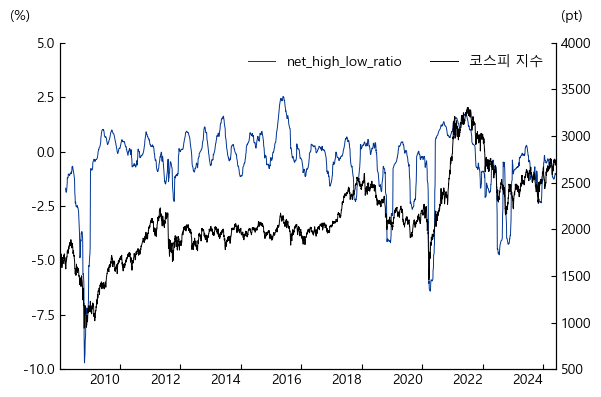

In [11]:
plot_data_df = pd.DataFrame([krx_52highlow_5days_df.net_high_low_ratio*100, kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

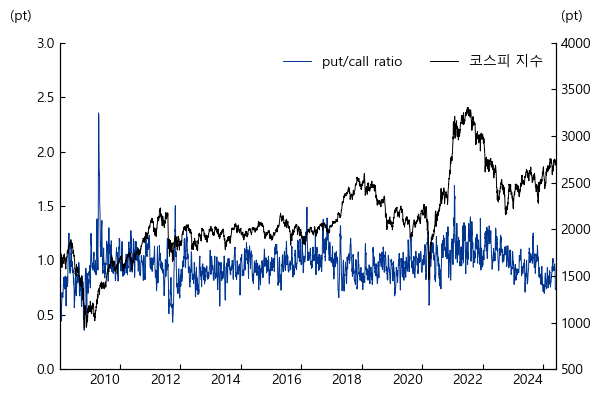

In [12]:
plot_data_df = pd.DataFrame([put_call_5d_sum['put/call ratio'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

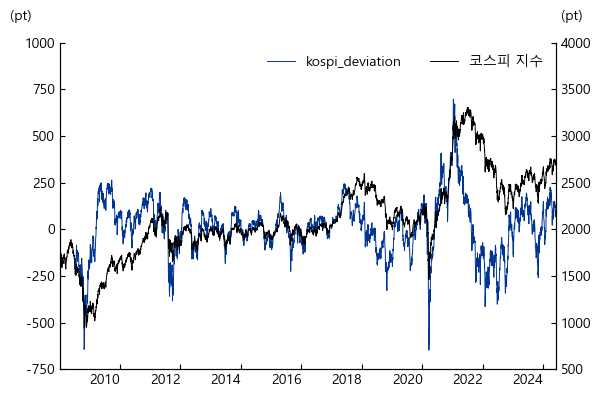

In [13]:
plot_data_df = pd.DataFrame([kospi_index_df['kospi_deviation'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

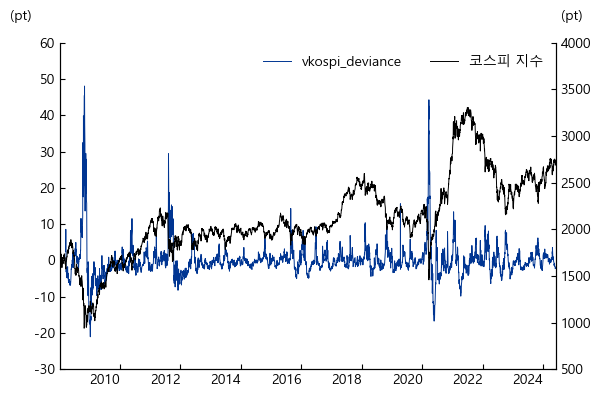

In [14]:
plot_data_df = pd.DataFrame([vkospi_df['vkospi_deviance'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

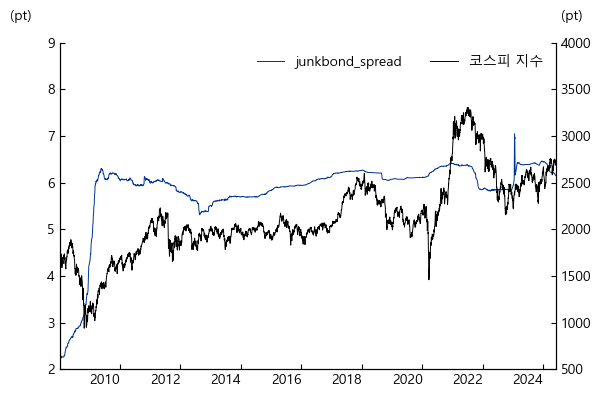

In [15]:
plot_data_df = pd.DataFrame([junk_bond_spread_df['junkbond_spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

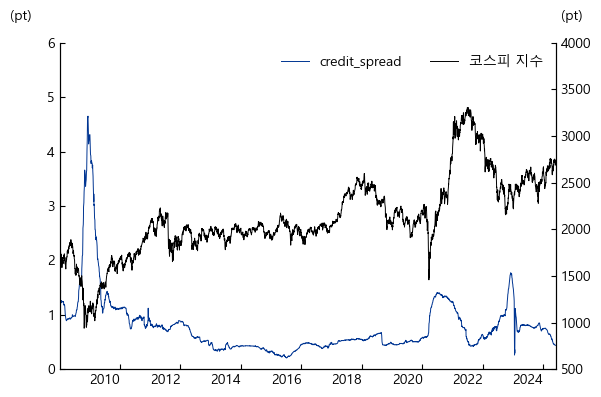

In [16]:
plot_data_df = pd.DataFrame([junk_bond_spread_df['credit_spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

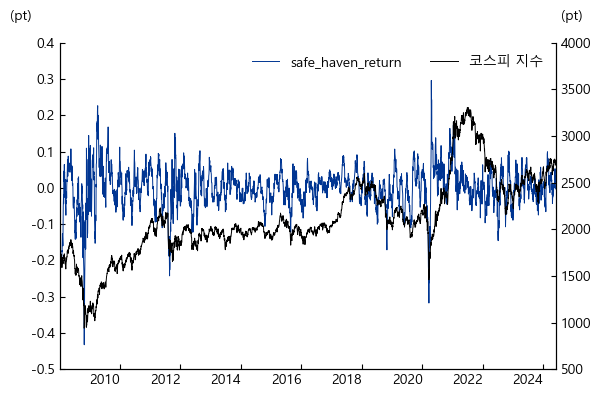

In [17]:
plot_data_df = pd.DataFrame([safe_haven_demand_df['safe_haven_return'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

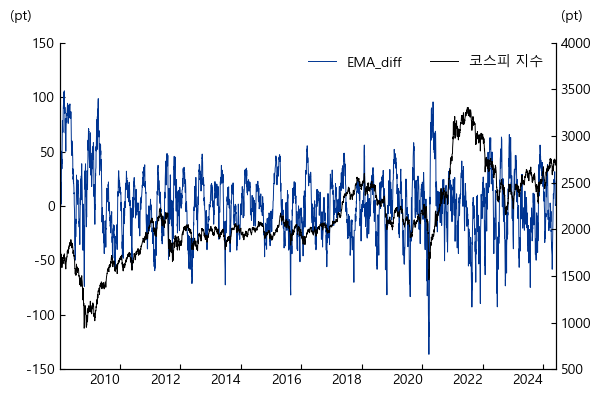

In [18]:
plot_data_df = pd.DataFrame([mcclellan_df['EMA_diff'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

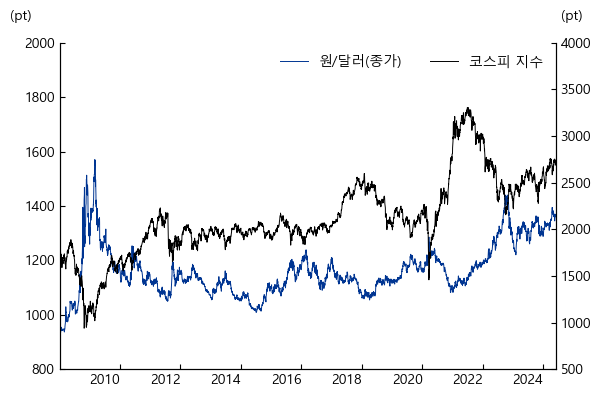

In [19]:
plot_data_df = pd.DataFrame([tidy_data['원/달러(종가)'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

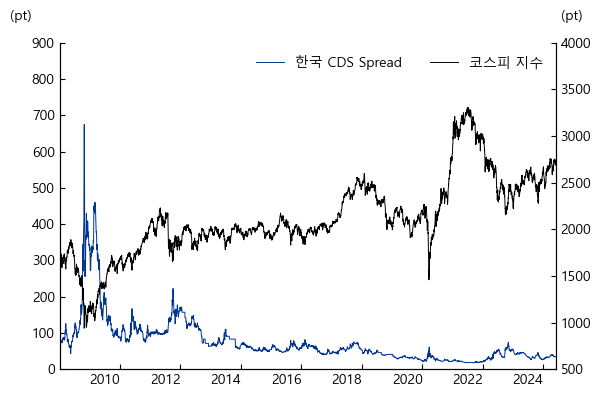

In [20]:
plot_data_df = pd.DataFrame([tidy_data['한국 CDS Spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

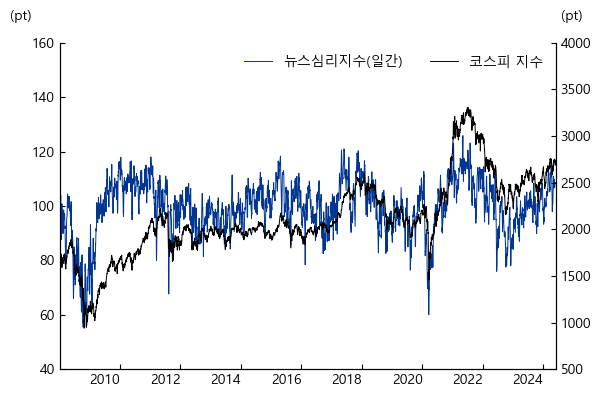

In [21]:
plot_data_df = pd.DataFrame([tidy_data['뉴스심리지수(일간)'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)